# Legoset classification with Keras and Tensorflow

This notebook is based on an in-class exercise at [Propulsion Academy](https://propulsion.academy/).

The fine-tuning of the network was further inspired by these articles:
- https://medium.com/@kenneth.ca95/a-guide-to-transfer-learning-with-keras-using-resnet50-a81a4a28084b
- https://towardsdatascience.com/learning-rate-schedules-and-adaptive-learning-rate-methods-for-deep-learning-2c8f433990d1


## Import libraries

In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 14})
import seaborn as sns
sns.set_palette("muted")

from datetime import datetime
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight

!pip install -U tensorboard_plugin_profile
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam, Nadam

import os
import PIL

from google.colab import drive

Requirement already up-to-date: tensorboard_plugin_profile in /usr/local/lib/python3.6/dist-packages (2.4.0)


In [2]:
#drive.flush_and_unmount()
drive.mount('/gdrive', force_remount=True)

Mounted at /gdrive


In [3]:
# locate data in the gdrive
project_dir = "/gdrive/MyDrive/Colab Notebooks/Legosets_classif"

images_dir = project_dir + '/images'
%cd {project_dir} 
%pwd

/gdrive/MyDrive/Colab Notebooks/Legosets_classif


'/gdrive/MyDrive/Colab Notebooks/Legosets_classif'

## Import the data frame with the image names

The data and images used here were scraped from ads on [Ricardo](https://www.ricardo.ch/). The corresponding code is available in one of my other repos: https://github.com/Alessine/ricardo_webscraping.

In [4]:
legosets_raw = pd.read_csv("lego_sets.csv", index_col = 0)

In [5]:
legosets_df = legosets_raw.copy()

In [6]:
# Basic cleaning of the data set
legosets_df = legosets_df.drop_duplicates(subset = "image_url")
legosets_df = legosets_df.dropna(axis = 0, subset = ["title"])

In [7]:
legosets_df.head()

,line,title,image_url,scraped_at,image_name,next_bid_auction,price_buy_now,ends_on,time_remaining,sale_type
0,starwars,Lego Star Wars Sammlung,https://img.ricardostatic.ch/t_1800x1350/pl/11...,2020-12-27 15:13:55,0_legosets.jpg,NaN,330.0,2020-12-29 10:25:00,1 days 19:11:05,buy_now
1,starwars,Lego Star Wars 75080 AAT,https://img.ricardostatic.ch/t_1800x1350/pl/11...,2020-12-27 15:13:58,1_legosets.jpg,NaN,59.0,2021-01-03 14:40:00,6 days 23:26:02,buy_now
2,starwars,Lego SW Minifigur Biggs Darklighter,https://img.ricardostatic.ch/t_1800x1350/pl/11...,2020-12-27 15:14:02,2_legosets.jpg,2.0,NaN,2020-12-27 20:30:00,0 days 05:15:58,auction
3,starwars,Lego SW Minifigur Obi Wan Kenobi,https://img.ricardostatic.ch/t_1800x1350/pl/11...,2020-12-27 15:14:06,3_legosets.jpg,1.0,NaN,2020-12-27 20:28:00,0 days 05:13:54,auction
4,starwars,Star Wars Battle Pack,https://img.ricardostatic.ch/t_1800x1350/pl/11...,2020-12-27 15:14:10,4_legosets.jpg,8.0,NaN,2020-12-27 16:55:00,0 days 01:40:50,auction


In [8]:
len(legosets_df), legosets_df.value_counts("line")

(1051, line
 duplo       356
 starwars    354
 technic     341
 dtype: int64)

## Split the data into train, validation and test sets

In [9]:
train_all, test = train_test_split(legosets_df, test_size=0.1)
train, val = train_test_split(train_all, test_size=0.1)
train.shape, val.shape, test.shape

((850, 10), (95, 10), (106, 10))

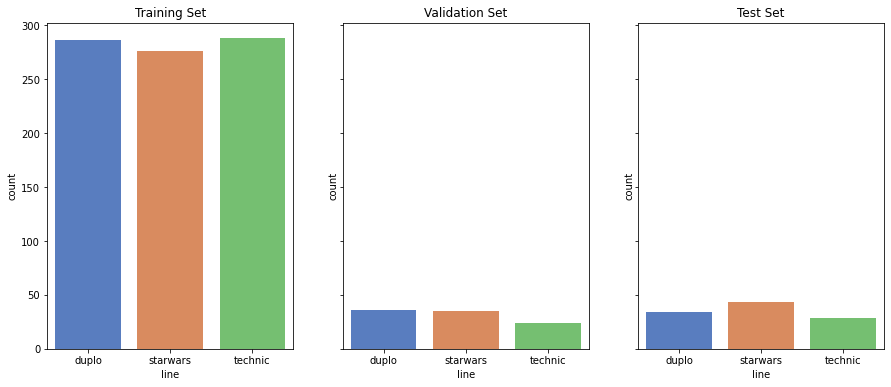

In [10]:
fig, axs = plt.subplots(1, 3, figsize = (15, 6), sharey = True)

sns.countplot(data = train.sort_values("line"), x = "line", ax = axs[0])
sns.countplot(data = val.sort_values("line"), x = "line", ax = axs[1])
sns.countplot(data = test.sort_values("line"), x = "line", ax = axs[2])

axs[0].set_title("Training Set")
axs[1].set_title("Validation Set")
axs[2].set_title("Test Set");

In [11]:
x_col = 'image_name' # column in the df with local paths to images
y_col = "line" # column in the df with the names of the classes

print("'{}' column contains {} unique classes".format(y_col, train[y_col].unique().shape[0]))

'line' column contains 3 unique classes


## Image preprocessing and augmentation

Image augmentation can help prevent overfitting and improve the results. However, it should not distort the images so much that the classification is no longer possible. The simple options that I have chosen already showed a big improvement in the accuracy of the classifications.

Additionally, the images also need to be scaled to the right input size and the pixels to values between 0 and 1.

In [12]:
IMG_SIZE = 224
batch_size = 50

#need to pass the class names to the .flow_from_dataframe method
train_classes = train[y_col].unique()
train_classes = np.sort(train_classes).tolist()

datagen_train = tf.keras.preprocessing.image.ImageDataGenerator(
                      rescale=1./255,
                      width_shift_range=0.2,
                      height_shift_range=0.2,
                      #zoom_range=[0.9, 1.1],
                      brightness_range=(0.9,1.1)
                      )

train_generator = datagen_train.flow_from_dataframe(
    dataframe = train,
    directory = images_dir,
    shuffle = True,
    x_col = x_col,
    y_col = y_col,
    classes = train_classes,
    class_mode = 'sparse',       # Sparse because all the labels are saved in the same column.
    target_size = (IMG_SIZE, IMG_SIZE), 
    batch_size = batch_size)

Found 850 validated image filenames belonging to 3 classes.


In [13]:
train_classes

['duplo', 'starwars', 'technic']

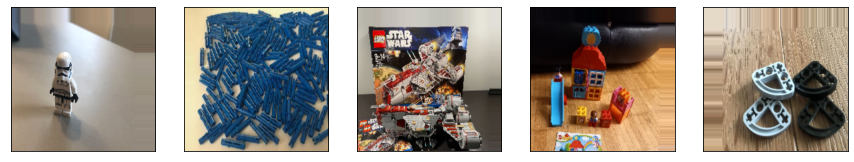

In [14]:
# Plot 5 images:
sample_training_images, _ = next(train_generator)
fig, axs = plt.subplots(1, 5, figsize = (15, 5))
for i in range(0, 5):
  axs[i].imshow(sample_training_images[i])
  axs[i].set_xticks([])
  axs[i].set_yticks([]);

The validation and test sets only need to be rescaled.

In [15]:
datagen_val=tf.keras.preprocessing.image.ImageDataGenerator(
                      rescale=1./255
                      )

val_generator=datagen_val.flow_from_dataframe(
    dataframe=val,
    directory=images_dir, 
    x_col=x_col,
    y_col=y_col,
    class_mode='sparse',
    classes=train_classes,
    shuffle=False,
    target_size=(IMG_SIZE, IMG_SIZE), 
    batch_size=batch_size)

test_generator = datagen_val.flow_from_dataframe(
    dataframe=test,
    directory=images_dir, 
    x_col=x_col,
    y_col=y_col,
    class_mode='sparse',
    classes=train_classes,
    shuffle=False,
    target_size=(IMG_SIZE, IMG_SIZE), 
    batch_size=batch_size)

Found 95 validated image filenames belonging to 3 classes.
Found 106 validated image filenames belonging to 3 classes.


## Defining other model inputs

In [16]:
# The number of steps depends on the number of images and the batch size. It needs to be rounded to integers.
steps_train = round(train_generator.n / batch_size)
steps_val = round(val_generator.n / batch_size)
steps_test = round(test_generator.n / batch_size)

In [17]:
train_generator.n, steps_train

(850, 17)

In [18]:
# This creates lists of all the class labels in the training and the test set.

cls_train = train_generator.classes
cls_test = test_generator.classes
len(cls_train)

850

In [19]:
# Calculate the class weights based on the labels in the training set.

class_weight = compute_class_weight(class_weight='balanced',
                                    classes=np.unique(cls_train),
                                    y=cls_train)
class_weight

array([0.99067599, 1.02657005, 0.9837963 ])

In [20]:
# Turn into dictionary
class_weight_dict = {i : class_weight[i] for i in range(0, len(class_weight))}
class_weight_dict

{0: 0.9906759906759907, 1: 1.0265700483091786, 2: 0.9837962962962963}

## Building the model

In [21]:
# Load the ResNet50 model without the top layers.
model_name = 'resnet50_v01'
model = tf.keras.applications.resnet50.ResNet50(input_shape = (224,224,3),
                                              include_top = False,
                                              weights = 'imagenet',
                                                    )

94773248/94765736 [==============================] - 1s 0us/step


In [22]:
# This is what the structure looks like.
model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In order to apply the ResNet50 model to this specific data set, I added a couple of new layers as the top. The final output now consists of three probabilities, corresponding to the classes of the lego sets.

In [23]:
# Create a new model with resnet

last_conv_layer = model.get_layer('conv5_block3_out')
conv_model = Model(inputs=model.input,
                   outputs=last_conv_layer.output)

new_model = Sequential()

new_model.add(conv_model)

new_model.add(tf.keras.layers.Dense(256, activation='relu'))
new_model.add(tf.keras.layers.Dropout(0.5))
new_model.add(tf.keras.layers.BatchNormalization())
new_model.add(tf.keras.layers.Dense(128, activation='relu'))
new_model.add(tf.keras.layers.Dropout(0.5))
new_model.add(tf.keras.layers.GlobalAveragePooling2D())
new_model.add(tf.keras.layers.Dense(3, activation='softmax'))   # Softmax activation function returns probabilities.

In [24]:
# Make the model trainable and define from what layers onwards
conv_model.trainable = True

fine_tune_at = 143  # This means only the last block will be trainable.

# Freeze all the layers before the `fine_tune_at` layer
for layer in conv_model.layers[:fine_tune_at]:
  layer.trainable =  False

## Compiling the model

The learning rate should be low, so the weights from the ResNet50 model change only slowly during training.

In [28]:
base_learning_rate = 2e-5
optimizer = Nadam(lr=base_learning_rate/5)
loss = 'sparse_categorical_crossentropy'
lst_metrics = ['sparse_categorical_accuracy']

new_model.compile(optimizer=optimizer, loss=loss, metrics=lst_metrics)
new_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model (Functional)           (None, 7, 7, 2048)        23587712  
_________________________________________________________________
dense (Dense)                (None, 7, 7, 256)         524544    
_________________________________________________________________
dropout (Dropout)            (None, 7, 7, 256)         0         
_________________________________________________________________
batch_normalization (BatchNo (None, 7, 7, 256)         1024      
_________________________________________________________________
dense_1 (Dense)              (None, 7, 7, 128)         32896     
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 7, 128)         0         
_________________________________________________________________
global_average_pooling2d (Gl (None, 128)               0

## Defining callbacks

In [29]:
# Use Tensorboard
logs = "logs/" + datetime.now().strftime("%Y%m%d-%H%M%S")

tboard_callback = tf.keras.callbacks.TensorBoard(log_dir = logs,
                                                 histogram_freq = 1,
                                                 profile_batch = '500,520')

# Can use this at a later point.

In [30]:
# Early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor = 'val_loss', min_delta = 0.005, patience = 10, verbose = 1,
    mode = 'auto', baseline = None, restore_best_weights = True
)

In [31]:
# Learning rate scheduler
def scheduler(epoch, lr):
  if epoch < 20:
    return lr
  else:
    return lr * tf.math.exp(-0.1)

lr_schedule = tf.keras.callbacks.LearningRateScheduler(scheduler)

# I tried this, but with the Adam or Nadam optimizer it does not yield better results.

## Training the model

In [32]:
# A high number of epochs is fine, since training stops once the loss stops to decrease.
epochs = 120
history = new_model.fit(train_generator,
                    epochs = epochs,
                    steps_per_epoch = steps_train,
                    class_weight = class_weight_dict,
                    validation_data = val_generator,
                    callbacks = [
                                 tboard_callback, 
                                 early_stopping,
                          #       lr_schedule
                                 ])

Epoch 1/120
17/17 [==============================] - 278s 16s/step - loss: 1.1660 - sparse_categorical_accuracy: 0.3535 - val_loss: 1.3534 - val_sparse_categorical_accuracy: 0.4000
Epoch 2/120
17/17 [==============================] - 39s 2s/step - loss: 1.1211 - sparse_categorical_accuracy: 0.3903 - val_loss: 1.2919 - val_sparse_categorical_accuracy: 0.4000
Epoch 3/120
17/17 [==============================] - 39s 2s/step - loss: 1.0618 - sparse_categorical_accuracy: 0.4386 - val_loss: 1.2505 - val_sparse_categorical_accuracy: 0.3579
Epoch 4/120
17/17 [==============================] - 39s 2s/step - loss: 1.0321 - sparse_categorical_accuracy: 0.4518 - val_loss: 1.2199 - val_sparse_categorical_accuracy: 0.2737
Epoch 5/120
17/17 [==============================] - 39s 2s/step - loss: 1.0345 - sparse_categorical_accuracy: 0.4534 - val_loss: 1.1991 - val_sparse_categorical_accuracy: 0.2526
Epoch 6/120
17/17 [==============================] - 39s 2s/step - loss: 0.9982 - sparse_categorical_ac

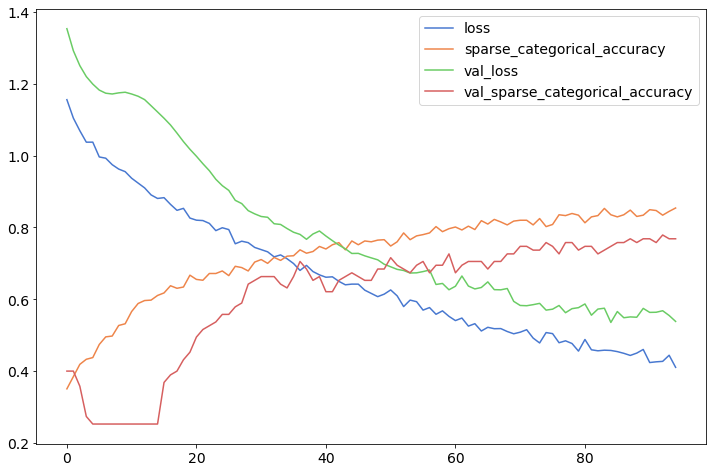

In [33]:
pd.DataFrame(history.history).plot(figsize = (12, 8));

In [34]:
new_model.save(f"{project_dir}/{datetime.now().strftime('%Y%m%d-%H%M%S')}_resnet50_model")

INFO:tensorflow:Assets written to: /gdrive/MyDrive/Colab Notebooks/Legosets_classif/20210101-193443_resnet50_model/assets


In [35]:
#new_model = tf.keras.models.load_model(f"{project_dir}/20201230-205011_resnet50_model")

## Testing the model

In [36]:
test_history = new_model.predict(
                        test_generator,
                        steps=steps_test,
                        callbacks=None,
                        max_queue_size=10,
                        workers=-1,
                        use_multiprocessing=False,
                        verbose=1)

2/2 [==============================] - 17s 15s/step


## Evaluating the model

In [37]:
# Results data frame
df_test_results = pd.DataFrame()
df_test_results['y_true'] = test_generator.labels[:100]
df_test_results['y_pred'] = test_history.argmax(axis = -1)
df_test_results.head()

,y_true,y_pred
0,0,0
1,1,1
2,1,1
3,1,0
4,2,2


In [38]:
# Print the classification report
print(classification_report(df_test_results['y_true'], 
                            df_test_results['y_pred'],
                            target_names = train_classes))

              precision    recall  f1-score   support

       duplo       0.81      0.76      0.78        33
    starwars       0.81      0.74      0.77        39
     technic       0.67      0.79      0.72        28

    accuracy                           0.76       100
   macro avg       0.76      0.76      0.76       100
weighted avg       0.77      0.76      0.76       100



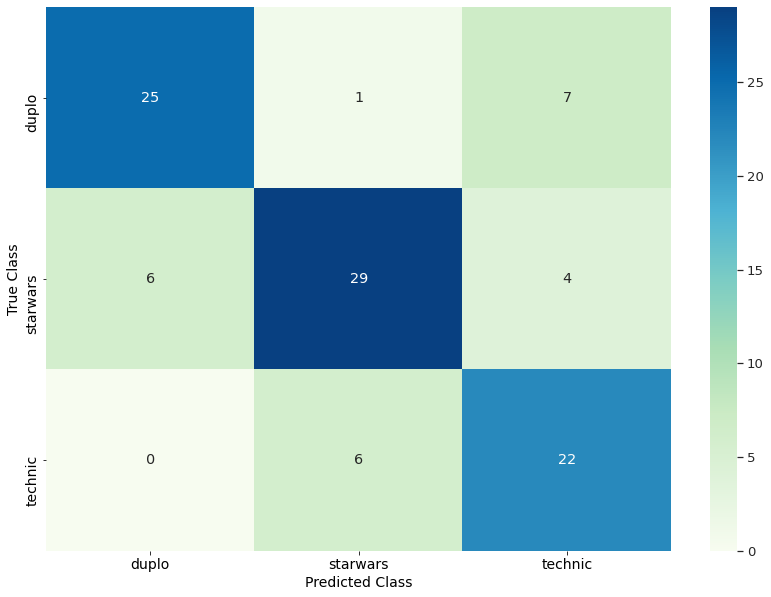

In [39]:
# Confusion matrix
labels = np.sort(df_test_results['y_true'].unique())
conf_mat = metrics.confusion_matrix(df_test_results['y_true'], 
                                    df_test_results['y_pred'],
                                    labels = labels)

df_conf = pd.DataFrame(conf_mat, columns = train_classes, index = train_classes)

fig, ax = plt.subplots(figsize=(14,10))
sns.set(font_scale=1.2)
sns.heatmap(df_conf, annot = True, ax = ax, cmap = "GnBu")
ax.set_xlabel("Predicted Class")
ax.set_ylabel("True Class")
plt.show()

## Showing some of the predictions

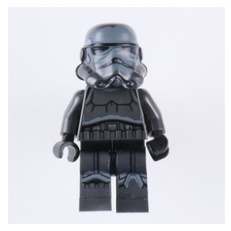

Probabilities: [0.003 0.82  0.177]
Predicted class: starwars

true class: starwars


In [40]:
input_shape = (224, 224)
row = test.iloc[2,:]

image_path = os.path.join(images_dir, row['image_name'])

img = PIL.Image.open(image_path)
img_resized = img.resize(input_shape, PIL.Image.LANCZOS)

# Plot the image.
plt.imshow(img_resized)
plt.xticks([])
plt.yticks([])
plt.show()

# Print the prediction and the true class.
print(f"Probabilities: {test_history[2].round(3)}")
print(f"Predicted class: {train_classes[df_test_results['y_pred'][2]]}")
print('\ntrue class:', train_classes[df_test_results['y_true'][2]])

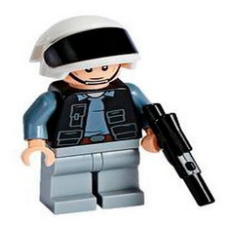

Probabilities: [0.009 0.604 0.387]
Predicted class: starwars

true class: starwars


In [41]:
input_shape = (224, 224)
row = test.iloc[30,:]

image_path = os.path.join(images_dir, row['image_name'])

img = PIL.Image.open(image_path)
img_resized = img.resize(input_shape, PIL.Image.LANCZOS)

# Plot the image.
plt.imshow(img_resized)
plt.xticks([])
plt.yticks([])
plt.show()

# Print the prediction and the true class.
print(f"Probabilities: {test_history[30].round(3)}")
print(f"Predicted class: {train_classes[df_test_results['y_pred'][30]]}")
print('\ntrue class:', train_classes[df_test_results['y_true'][30]])

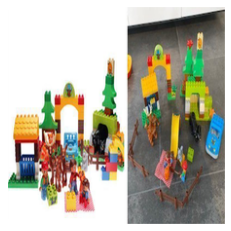

Probabilities: [0.111 0.281 0.608]
Predicted class: technic

true class: duplo


In [42]:
input_shape = (224, 224)
row = test.iloc[81,:]

image_path = os.path.join(images_dir, row['image_name'])

img = PIL.Image.open(image_path)
img_resized = img.resize(input_shape, PIL.Image.LANCZOS)

# Plot the image.
plt.imshow(img_resized)
plt.xticks([])
plt.yticks([])
plt.show()

# Print the prediction and the true class.
print(f"Probabilities: {test_history[81].round(3)}")
print(f"Predicted class: {train_classes[df_test_results['y_pred'][81]]}")
print('\ntrue class:', train_classes[df_test_results['y_true'][81]])